# Optimisation bi-objective de Markowitz - Niveau 1

In [13]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
import scipy.optimize as sco

project_root = os.path.dirname(os.path.abspath(''))
raw_data = os.path.join(project_root, 'data', 'raw')
processed_data = os.path.join(project_root, 'data', 'processed')
images_path = os.path.join(project_root, 'reports', 'figures')

if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_prep import all_sectors

# Chargement des données
df = pd.read_csv(os.path.join(processed_data, 'daily_returns.csv'), index_col='Date', parse_dates=True)

In [14]:
# Calcul de Mu (Moyenne annualisée)
mu = df.mean() * 252 # 252 : jours de bourses dans une année

# Calcul de Sigma (Matrice de Covariance annualisée)
sigma = df.cov() * 252

print(f"Mu :\n{mu.head()}\nShape : {mu.shape}\n") 
print(f"Sigma :\n{sigma.head(1)}\nShape : {sigma.shape}")


Mu :
LIN    0.161983
APD    0.132600
ECL    0.123445
SHW    0.180060
PPG    0.055276
dtype: float64
Shape : (190,)

Sigma :
          LIN       APD       ECL       SHW       PPG       MLM       VMC  \
LIN  0.051981  0.038536  0.035775  0.031132  0.037482  0.034791  0.031276   

          NUE      STLD       FCX  ...      META      DIS      NFLX       VZ  \
LIN  0.041839  0.042712  0.058578  ...  0.031919  0.02813  0.027094  0.01394   

            T      TMUS     CMCSA      CHTR        EA      TTWO  
LIN  0.019061  0.021917  0.025355  0.022996  0.020016  0.022334  

[1 rows x 190 columns]
Shape : (190, 190)


### Fonctions Objectifs  f1 et f2

In [15]:
# Fonction de cout f1 : Maximise le rendement (donc minimise -R)
def f1_rendement(w, mu):
    return -w.T @ mu

# Fonction de cout f2 : Minimise le risque (variance)
def f2_risque(w, sigma):
    return w.T @ sigma @ w

# Fonction utilitaire pour récupérer Rendement, Volatilité et Sharpe Ratio d'un poids w
def get_rend_vol_sr(w, mu, sigma):
    rend = w @ mu
    vol = np.sqrt(w.T @ sigma @ w)
    sr = rend / vol
    return rend, vol, sr

### Optimisation - Recherche du front de Pareto (Markowitz)

In [16]:
# Nombres d'actions disponibles
num_assets = len(mu)

# Contraintes de base
constraints_base = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1} # Somme(w) = 1
bounds = tuple((0, 1) for _ in range(num_assets)) # 0 <= w <= 1

# Initialisation : toutes les actions ont le meme poids
w0 = np.ones(num_assets) / num_assets 

# Fonction de maximisation (- minimisation)
def min_neg_sharpe(w, mu, sigma):
    rend, vol, _ = get_rend_vol_sr(w, mu, sigma)
    return -rend / vol

res_sharpe = sco.minimize(
    min_neg_sharpe,                     # La fonction à minimiser (la boussole)
    w0,                                 # Le point de départ
    args=(mu, sigma),                   # Les données nécessaires au calcul (Rendements, Covariance)
    method='SLSQP',                     # L'algo SLSQP (Sequential Least SQuares Programming), adapté aux problèmes convexes
    bounds=bounds,                      # Les bornes (0 - 1)
    constraints=constraints_base        # La contrainte (Somme = 1)
)
w_sharpe = res_sharpe.x # poids gagnants (portefeuille optimal)
rend_sharpe, vol_sharpe, _ = get_rend_vol_sr(w_sharpe, mu, sigma)

# Recherche de la frontière de Pareto
target_returns = np.linspace(mu.min(), mu.max(), 200) # 200 niveaux de rendement cibles
efficient_frontier_vol = []

for target in target_returns:
    # On ajoute la contrainte : Rendement == target
    cons_loop = (constraints_base, {'type': 'eq', 'fun': lambda x: -f1_rendement(x, mu) - target})
    
    # On minimise le risque f2 (variance) sous contrainte de rendement
    res = sco.minimize(
        f2_risque, # objectif : minimiser la variance (le risque)
        w0,
        args=(sigma,), 
        method='SLSQP',
        bounds=bounds,
        constraints=cons_loop
    )
    # On stocke la volatilité (écart-type) mininmum trouvée (racine de la variance f2) pour le plot
    efficient_frontier_vol.append(np.sqrt(res.fun))

### Visualisation du front de Pareto

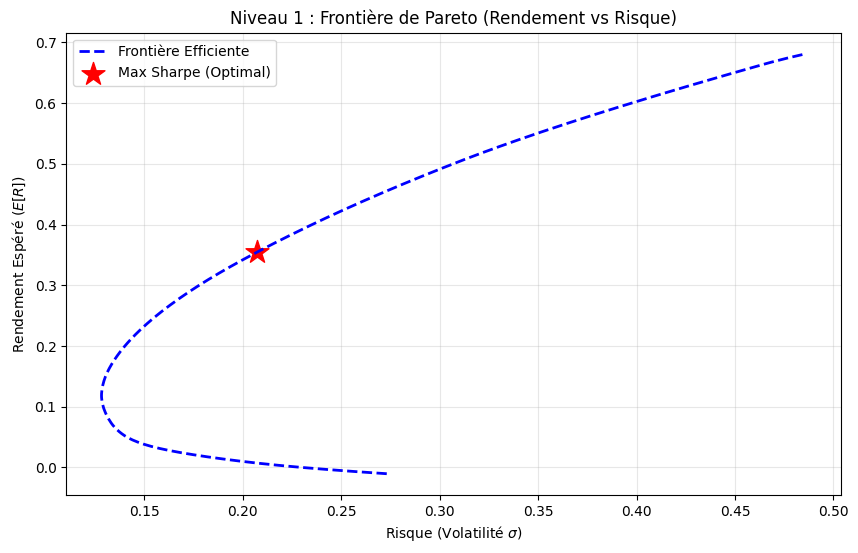

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(efficient_frontier_vol, target_returns, 'b--', linewidth=2, label='Front de Pareto')
plt.scatter(vol_sharpe, rend_sharpe, c='red', marker='*', s=300, label='Max Sharpe (Optimal)') # point optimal
plt.title('Niveau 1 : Front de Pareto (Rendement vs Risque)')
plt.xlabel(r'Risque (Volatilité $\sigma$)')
plt.ylabel(r'Rendement Espéré ($E[R]$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(images_path + 'niveau_1_front_de_pareto.png')
plt.show()

Le graphique obtenu présente la forme caractéristique d'une hyperbole, typique de la théorie de Markowitz. L'analyse de la courbe révèle trois phases distinctes :

- **La Zone d'Inefficience (Partie basse, $R < 15\%$) :**
    * Dans cette zone, nous observons un phénomène fascinant : **le risque diminue alors que le rendement augmente**.
    * Cela s'explique par la corrélation imparfaite entre les actifs. En combinant des actifs mal corrélés, nous arrivons à réduire la volatilité globale du portefeuille à un niveau inférieur à celui des actifs individuels les moins risqués.
    * Un investisseur rationnel ne choisira jamais un portefeuille dans cette zone, car il peut obtenir un meilleur rendement pour un  niveau de risque inférieur en se projetant verticalement sur la partie supérieure de la courbe.

- **Le Point de Variance Minimale (vers $\sigma \approx 13\%$) :**
    * C'est le sommet de la courbe (le point le plus à gauche). Il représente le portefeuille le plus sûr qu'il est mathématiquement possible de construire avec cet univers d'investissement, indépendamment du rendement.

-  **Le Front de Pareto (Partie haute, $R > 15\%$) :**
    * C'est la partie de la courbe située au-dessus du point de variance minimale.
    * Ici, la logique financière standard s'applique : **il n'est plus possible d'augmenter le rendement espéré sans accepter une augmentation du risque**.
    * C'est sur cette partie que se trouve notre **Portefeuille Optimal (Max Sharpe)**, symbolisé par l'étoile rouge, qui offre le meilleur rendement par unité de risque supplémentaire.
---

### Visualisation du Portefeuille Optimal

Nombre d'actifs sélectionnés : 15 / 190

Allocations sélectionnées :
LLY     24.88%
NVDA    20.15%
TMUS     9.11%
COST     8.60%
TSLA     4.83%
AZO      4.78%
CHD      4.44%
ANET     4.33%
NOC      3.90%
WMT      3.67%
NFLX     3.15%
ORLY     2.85%
KR       1.58%
AVGO     1.51%
MCD      1.49%
dtype: object


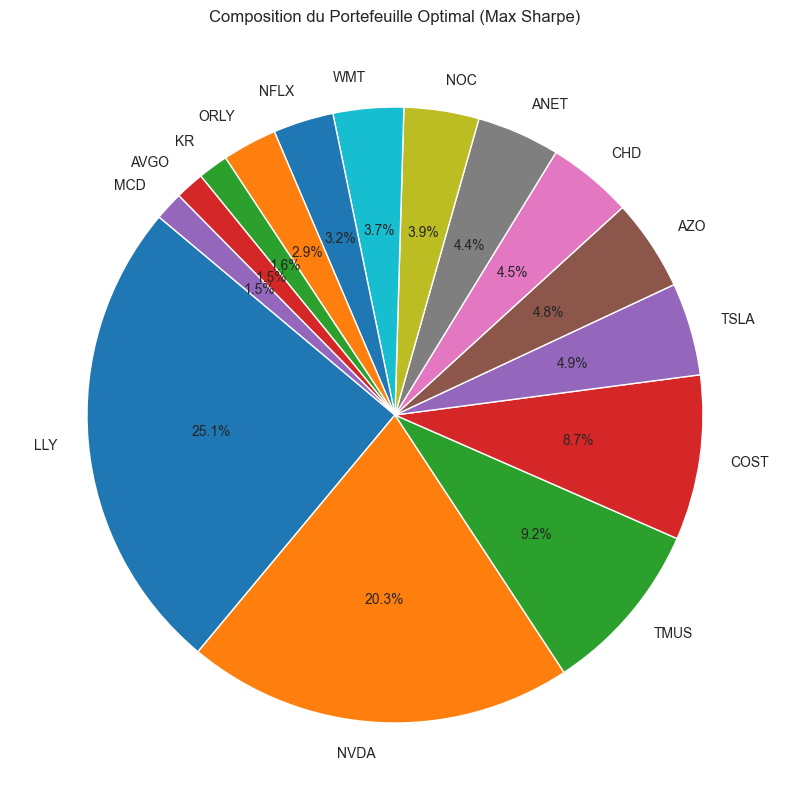

In [17]:
portefeuille_series = pd.Series(w_sharpe, index=df.columns)

# On ne garde que les positions significatives (> 1%)
significant_positions = portefeuille_series[portefeuille_series > 0.01].sort_values(ascending=False)

print(f"Nombre d'actifs sélectionnés : {len(significant_positions)} / {num_assets}")
print("\nAllocations sélectionnées :")
print(significant_positions.apply(lambda x: f"{x:.2%}"))

# Pie Chart
plt.figure(figsize=(10, 10))
plt.pie(significant_positions, labels=significant_positions.index, autopct='%1.1f%%', startangle=140)
plt.title('Composition du Portefeuille Optimal (Max Sharpe)')
plt.savefig(images_path + 'niveau_1_pie_chart_allocations.png')
plt.show()

L'optimisation de Markowitz a sélectionné une allocation très tranchée pour maximiser le Ratio de Sharpe sur la période 2015-2024.

**Observation de la concentration :**
* Nous avons une **concentration extrême** sur deux titres majeurs : **Eli Lilly (LLY, ~25%)** et **Nvidia (NVDA, ~20%)**.
* Ces deux positions représentent à elles seules **près de 45%** du capital total.
* Le reste du portefeuille est composé d'une douzaine d'autres actifs (Costco, Tesla, etc.).

L'algorithme se base sur les rendements passés ($\mu$) et la covariance historique ($\Sigma$).
* **LLY** a connu une croissance exceptionnelle grâce au marché des médicaments contre l'obésité.
* **NVDA** a explosé avec l'essor de l'IA.
* Mathématiquement, l'optimiseur considère ces performances passées comme la norme future et alloue donc massivement du capital sur ces gagnants historiques.

---

### Analyse détaillée du Portefeuille Optimal

Analyse Détaillée du Portefeuille Optimal
Rendement Global Portefeuille : 35.44%
Risque Global Portefeuille    : 20.71%
Ratio de Sharpe Global        : 1.71


      Allocation (%)  Rendement Annuel (%)  Volatilité Annuelle (%)
LLY            24.88                 29.81                    27.87
NVDA           20.15                 68.13                    48.61
TMUS            9.11                 24.54                    26.12
COST            8.60                 23.16                    21.58
TSLA            4.83                 49.54                    57.16
AZO             4.78                 19.83                    25.64
CHD             4.44                 13.31                    20.99
ANET            4.33                 42.44                    42.30
NOC             3.90                 16.21                    24.15
WMT             3.67                 15.75                    21.13
NFLX            3.15                 38.56                    43.63
ORLY            2.85     

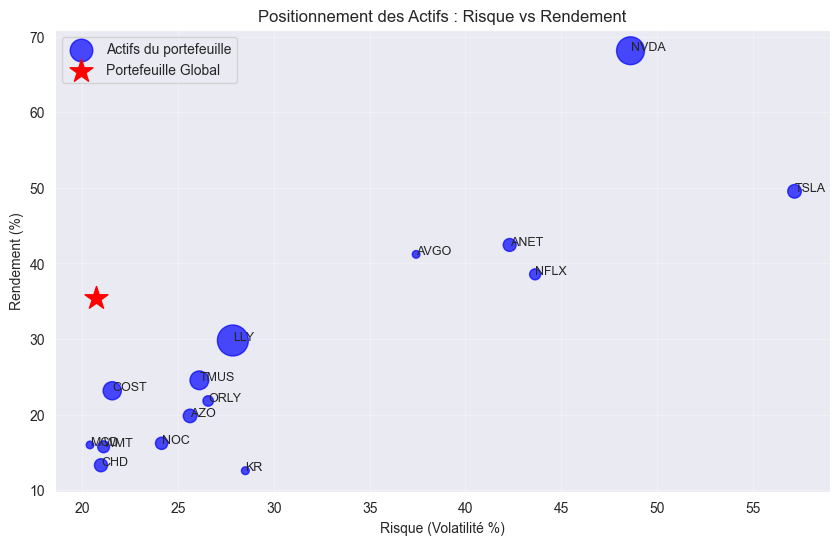

In [18]:
# Calcul des métriques individuelles pour chaque actif
individual_volatility = np.sqrt(np.diag(sigma)) # risque individuel (volatilité) = racine carrée de la diagonale de la matrice de covariance
individual_rendement = mu.values

# DataFrame récapitulatif
df_analysis = pd.DataFrame({
    'Allocation (%)': w_sharpe * 100,
    'Rendement Annuel (%)': individual_rendement * 100,
    'Volatilité Annuelle (%)': individual_volatility * 100
}, index=df.columns)

# Filtre pour ne garder que les actifs importants (> 1%)
df_analysis = df_analysis[df_analysis['Allocation (%)'] > 1.0].sort_values(by='Allocation (%)', ascending=False)

print("Analyse Détaillée du Portefeuille Optimal")
print(f"Rendement Global Portefeuille : {rend_sharpe:.2%}")
print(f"Risque Global Portefeuille    : {vol_sharpe:.2%}")
print(f"Ratio de Sharpe Global        : {rend_sharpe/vol_sharpe:.2f}\n\n")
print(df_analysis.round(2))

plt.figure(figsize=(10, 6))
plt.scatter(df_analysis['Volatilité Annuelle (%)'], df_analysis['Rendement Annuel (%)'], 
            s=df_analysis['Allocation (%)']*20, alpha=0.7, c='blue', label='Actifs du portefeuille')
# On ajoute les noms
for ticker in df_analysis.index:
    plt.text(df_analysis.loc[ticker, 'Volatilité Annuelle (%)'], 
             df_analysis.loc[ticker, 'Rendement Annuel (%)'], 
             ticker, fontsize=9)
plt.scatter(vol_sharpe*100, rend_sharpe*100, c='red', marker='*', s=300, label='Portefeuille Global') # on place le portefeuille global (Etoile Rouge)
plt.title('Positionnement des Actifs : Risque vs Rendement')
plt.xlabel('Risque (Volatilité %)')
plt.ylabel('Rendement (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig(images_path + 'niveau_1_analyse_detaillee.png')
plt.show()

Bien que mathématiquement optimal selon la théorie de Markowitz, ce portefeuille présente des risques concrets pour un investisseur.

#### 1. Le Biais Historique et le Risque de "Bulle"
L'allocation suppose que le futur ressemblera au passé. Or, investir 20% sur **Nvidia** après une hausse historique est dangereux. Si la bulle IA corrige ou si la croissance de Eli Lilly ralentit, le portefeuille subira une perte massive du à l'allocation hyper importante de ces 2 actifs. Le modèle ne prend pas en compte la valorisation fondamentale, seulement la statistique passée.

#### 2. Le Manque de Diversification "Réelle"
Avoir 190 actifs disponibles mais en choisir seulement 2 pour porter la moitié du risque contredit le principe de prudence. Une telle concentration expose le portefeuille au **risque idiosyncratique** (risque spécifique à une entreprise).

#### 3. Transition vers le Niveau 2 : La Cardinalité
C'est pour pallier ces défauts que le **Niveau 2** du projet est nécessaire. Nous allons introduire des contraintes opérationnelles ($C_{Op}$) :
* **Cardinalité stricte ($K$) :** Forcer le modèle à choisir un nombre défini d'actifs.
* **Bornes de poids :** Nous pourrions limiter le poids max d'un actif (ex: pas plus de 15%) pour forcer une diversification plus robuste et éviter de tout miser sur les gagnants du passé.